# Project: Don't Call Me Turkey

## Phase 1: Scikit-learn

**Bài toán:** Dự đoán tiếng động trong các clip có phải là tiếng gà tây?

## Khai báo các thư viện cần thiết

In [1]:
import json
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from collections import Counter
from sklearn.model_selection import KFold
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, VotingClassifier
from sklearn.svm import SVC
from sklearn.calibration import CalibratedClassifierCV
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score, StratifiedKFold
from sklearn.metrics import accuracy_score, classification_report, roc_auc_score, roc_curve, auc, confusion_matrix, ConfusionMatrixDisplay
from sklearn.preprocessing import StandardScaler

## Phân tích Dữ liệu Khám phá (EDA).

### Tải dữ liệu từ file JSON và xem kích thước và kiểu dữ liệu.

Loại dữ liệu chính: <class 'list'>
Loại phần tử đầu tiên: <class 'dict'>
Các khóa trong mỗi mẫu: dict_keys(['audio_embedding', 'is_turkey', 'vid_id', 'end_time_seconds_youtube_clip', 'start_time_seconds_youtube_clip']) 

Kiểu embedding: <class 'list'>
Chiều của 1 frame: 128 

Phân phối số lượng frame:
Counter({10: 1120, 9: 56, 2: 5, 6: 4, 8: 3, 5: 3, 4: 2, 3: 1, 7: 1})


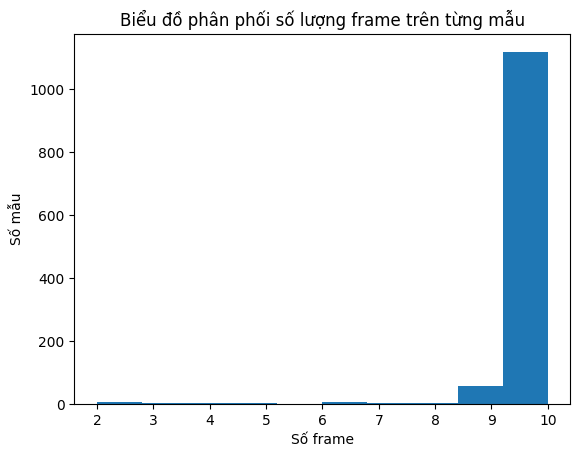

In [2]:
with open('train.json', 'r') as f:
    data = json.load(f)

# --- Thông tin cơ bản ---
print("Loại dữ liệu chính:", type(data))
print("Loại phần tử đầu tiên:", type(data[0]))
print("Các khóa trong mỗi mẫu:", data[0].keys(), '\n')

# --- Kiểm tra kích thước frame ---
embedding = data[0]['audio_embedding']
print("Kiểu embedding:", type(embedding))
print("Chiều của 1 frame:", len(embedding[0]), '\n')

# Thống kê số frame trên từng mẫu
frame_lengths = [len(item['audio_embedding']) for item in data]
print("Phân phối số lượng frame:")
print(Counter(frame_lengths))

plt.hist(frame_lengths)
plt.title("Biểu đồ phân phối số lượng frame trên từng mẫu")
plt.xlabel('Số frame')
plt.ylabel('Số mẫu')
plt.show()

- Theo mô tả, dữ liệu có các đặc trưng (feature):

|Tên feature|Ý nghĩa|
|---|---|
|audio_embedding | Chuỗi các vector đặc trưng có dạng list, mỗi vector gồm 128 chiều, biểu diễn đặc trưng của một frame âm thanh.|
|is_turkey | Nhãn (0 hoặc 1)|
|vid_id| mã ID của video|
| start_time_seconds_youtube_clip| thời điểm bắt đầu (trong video YouTube)|
| end_time_seconds_youtube_clip| thời điểm kết thúc|

- Ta nhận thấy, chỉ có 1120 mẫu là đúng chuẩn (10 frame). Còn lại 75 mẫu có số frame khác 10 → cần xử lý để dữ liệu đồng nhất .

**Kiểm tra missing value.**

In [3]:
df = pd.DataFrame(data)

In [4]:
print(df.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1195 entries, 0 to 1194
Data columns (total 5 columns):
 #   Column                           Non-Null Count  Dtype 
---  ------                           --------------  ----- 
 0   audio_embedding                  1195 non-null   object
 1   is_turkey                        1195 non-null   int64 
 2   vid_id                           1195 non-null   object
 3   end_time_seconds_youtube_clip    1195 non-null   int64 
 4   start_time_seconds_youtube_clip  1195 non-null   int64 
dtypes: int64(3), object(2)
memory usage: 46.8+ KB
None


⇒ Không tồn tại missing value.

**Xem mô tả, thống kê đặc trưng và phân phối của biến mục tiêu `is_turkey`.**

Số lượng mẫu mỗi lớp: 
 is_turkey
0    704
1    491
Name: count, dtype: int64

Tỉ lệ các lớp: 
 is_turkey
0    0.589121
1    0.410879
Name: proportion, dtype: float64


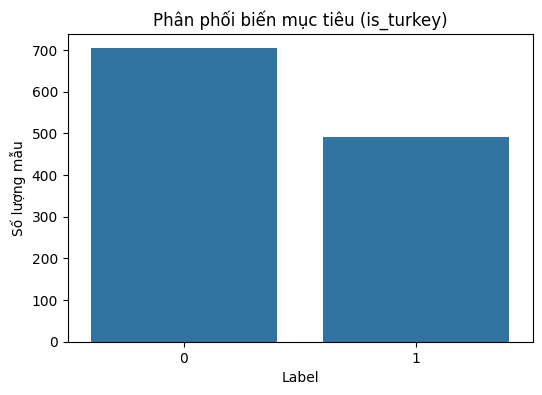

In [5]:
print('Số lượng mẫu mỗi lớp: \n', df['is_turkey'].value_counts())
print('\nTỉ lệ các lớp: \n', df['is_turkey'].value_counts(normalize=True))
plt.figure(figsize=(6,4))
sns.countplot(x='is_turkey', data=df)
plt.title('Phân phối biến mục tiêu (is_turkey)')
plt.xlabel('Label')
plt.ylabel('Số lượng mẫu')
plt.show()


### Hàm load lại dữ liệu đồng thời xử lý kích thức embedding.
- Cắt bớt nếu số frame > 10.

- Padding (bổ sung frame rỗng là 0) nếu số frame < 10.

- để chuẩn hóa về kích thước (10, 128) giúp đảm bảo mô hình có thể xử lý dữ liệu đầu vào một cách đồng nhất và ổn định.

In [6]:
def load_and_process_json(file_path, is_train=True):
    with open(file_path, 'r') as f:
        data = json.load(f)

    embeddings = []
    labels_or_ids = []

    for item in data:
        emb = item['audio_embedding']
        emb_np = np.array(emb)

        # Padding hoặc cắt bớt frame
        if emb_np.shape[0] < 10:
            pad_len = 10 - emb_np.shape[0]
            emb_np = np.vstack([emb_np, np.zeros((pad_len, 128))])
        elif emb_np.shape[0] > 10:
            emb_np = emb_np[:10]

        if emb_np.shape == (10, 128):
            embeddings.append(emb_np)
            if is_train:
                labels_or_ids.append(item['is_turkey'])
            else:
                labels_or_ids.append(item['vid_id'])

    X = np.array(embeddings)

    if is_train:
        y = np.array(labels_or_ids)
        return X, y
    else:
        ids = labels_or_ids
        return ids, X


**Tải dữ liệu từ tập train và tập test.**

In [7]:
x_train, y_train = load_and_process_json('train.json', is_train=True)
test_ids, x_test = load_and_process_json('test.json', is_train=False)

**Xử lý đặc trưng và Chuẩn hóa dữ liệu.**

Để cải thiện khả năng học của mô hình, các đặc trưng từ dữ liệu âm thanh ban đầu ((10, 128)) được biến đổi thành một vector đặc trưng phẳng và bổ sung thêm thông tin thống kê.

- Áp dụng .reshape(...) để "làm phẳng" toàn bộ thành vector 1 chiều có 1280 phần tử (10 × 128):

In [8]:
x_train_flat = x_train.reshape((x_train.shape[0], -1))
x_test_flat = x_test.reshape((x_test.shape[0], -1))

- Bổ sung các thông tin thống kê: Tính giá trị trung bình và độ lệch chuẩn theo trục thời gian (frame). Trung bình (mean) và độ lệch chuẩn (std) được tính theo từng chiều embedding, giúp mô hình hiểu được xu hướng và độ phân tán:

In [9]:
x_train_mean = np.mean(x_train, axis=1)
x_train_std = np.std(x_train, axis=1)
x_test_mean = np.mean(x_test, axis=1)
x_test_std = np.std(x_test, axis=1)

Ghép tất cả thành feature vector cuối cùng bằng np.hstack:

- Embedding phẳng (1280)

- Trung bình theo chiều (128)

- Độ lệch chuẩn theo chiều (128)

→ Tổng cộng: 1536 đặc trưng cho mỗi mẫu.

In [10]:
x_train_features = np.hstack([x_train_flat, x_train_mean, x_train_std])
x_test_features = np.hstack([x_test_flat, x_test_mean, x_test_std])

Chuẩn hóa đặc trưng (Feature Normalization)
- Sử dụng StandardScaler từ thư viện sklearn.preprocessing để đưa toàn bộ dữ liệu về phân phối chuẩn (mean=0, std=1).
- Điều này giúp tăng hiệu quả và độ ổn định khi huấn luyện mô hình, đặc biệt là với các thuật toán như SVM, Logistic Regression, hoặc MLP

In [11]:
scaler = StandardScaler()
x_train_features = scaler.fit_transform(x_train_features)
x_test_features = scaler.transform(x_test_features)

## Phát triển Mô hình (Model Development) và Đánh giá Mô hình (Model Evaluation).

### Hàm đánh giá mô hình

In [12]:
def evaluate_model(model, X_val, y_val, x_train_full, y_train_full, model_name="Model"):
    val_probs = model.predict_proba(X_val)[:, 1]
    val_preds = model.predict(X_val)
    val_auc = roc_auc_score(y_val, val_probs)
    fpr, tpr, _ = roc_curve(y_val, val_probs)

    # ROC curve
    plt.figure(figsize=(7, 5))
    plt.plot(fpr, tpr, label=f'ROC Curve (AUC = {val_auc:.2f})')
    plt.plot([0, 1], [0, 1], 'k--')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title(f'Validation ROC Curve - {model_name}')
    plt.legend()
    plt.grid()
    plt.show()

    # Confusion Matrix
    ConfusionMatrixDisplay.from_predictions(y_val, val_preds)
    plt.title(f"Confusion Matrix - {model_name}")
    plt.grid(False)
    plt.show()

    # Classification Report
    print("Classification Report:")
    print(classification_report(y_val, val_preds))

    # Cross-validation AUC
    cv_scores = cross_val_score(model, x_train_full, y_train_full, cv=10, scoring='roc_auc', n_jobs=-1)
    print(f"10-Fold CV AUC Scores:\n{cv_scores}")
    print(f"Mean AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

    # Boxplot
    plt.figure(figsize=(6, 4))
    plt.boxplot(cv_scores, vert=False)
    plt.title(f'10-Fold CV AUC Scores - {model_name}')
    plt.xlabel('AUC')
    plt.grid()
    plt.show()

    return val_auc

**Chia tập huấn luyện thành train/validation theo tỷ lệ 80/20**

In [13]:
X_train, X_val, y_train_split, y_val = train_test_split(
    x_train_features, y_train, test_size=0.2, random_state=42, stratify=y_train)

### Huấn luyện mô hình
- Mô tả thuật toán chính: Hai thuật toán chính được lựa chọn và sử dụng song song là **Support Vector Classifier (Support Vector Machine)** và **Logistic Regression**. Cả hai mô hình đều được tích hợp trong một thư viện học máy sklearn.
- Mục tiêu là khai thác ưu điểm của từng mô hình và nâng cao hiệu suất tổng thể thông qua học cộng tác.


### Mô hình Support Vector Machine
- Thuật toán Support Vector Machine với tính năng output xác suất (probability=True).

- Để cải thiện độ tin cậy của xác suất dự đoán, mô hình SVC được bao bọc bởi CalibratedClassifierCV nhằm hiệu chỉnh lại xác suất dự đoán, giúp mô hình đưa ra các dự đoán xác suất chuẩn xác hơn.

- Thiết kế thuật toán chi tiết:

    - Sử dụng mô hình CalibratedClassifierCV với 3-fold cross-validation (cv=3) để hiệu chỉnh xác suất đầu ra của SVC.

    - Kết hợp với phương pháp Grid Search để tìm kiếm kết hợp siêu tham số tối ưu cho mô hình.

    - Thuật toán tìm kiếm chi tiết trên không gian tham số như sau:

    - C: hệ số điều chỉnh biên (margin) của SVC với các giá trị [0.1, 1, 10]

    - kernel: kiểu hàm kernel của SVC, thử nghiệm các loại ['linear', 'rbf']

    - gamma: tham số điều chỉnh kernel RBF, thử nghiệm ['scale', 'auto']
- Tiêu chí đánh giá chính là roc_auc.
- Quy trình huấn luyện:
    - Đưa dữ liệu huấn luyện X_train và nhãn y_train_split vào thực hiện huấn luyện qua grid.fit().

    - Sau khi huấn luyện, chọn mô hình tốt nhất dựa trên kết quả tìm kiếm grid.best_estimator_.

    - Đánh giá mô hình trên tập validation với hàm evaluate_model để kiểm tra chất lượng phân loại và khả năng tổng quát hóa.

    - Dùng mô hình tốt nhất dự đoán xác suất trên tập test x_test_features.


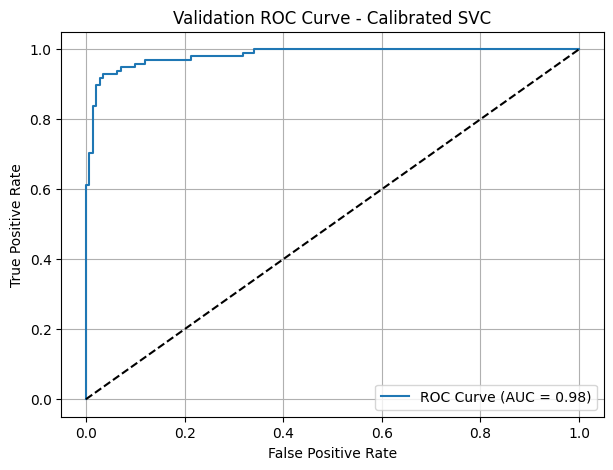

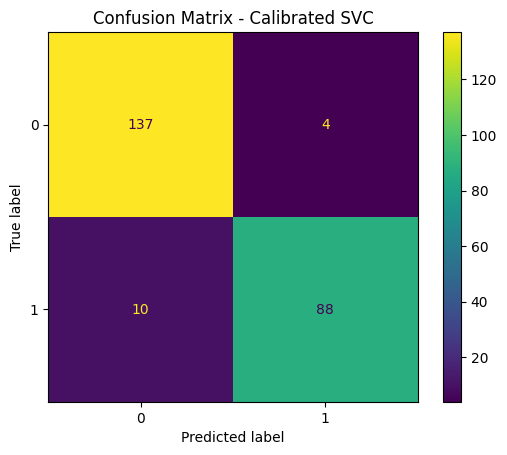

Classification Report:
              precision    recall  f1-score   support

           0       0.93      0.97      0.95       141
           1       0.96      0.90      0.93        98

    accuracy                           0.94       239
   macro avg       0.94      0.93      0.94       239
weighted avg       0.94      0.94      0.94       239

10-Fold CV AUC Scores:
[0.98562805 0.98505318 0.98878988 0.99913768 0.982      0.96588921
 0.99620991 0.97667638 0.99387755 0.99504373]
Mean AUC: 0.9868 ± 0.0096


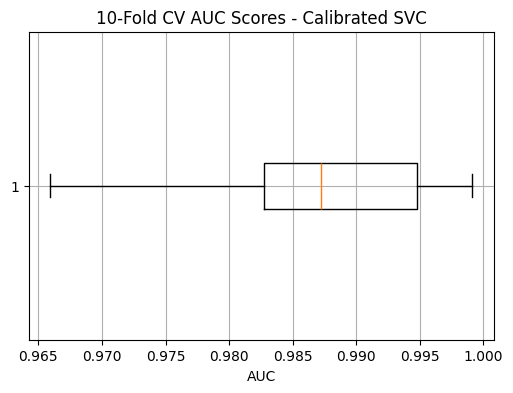

Best Parameters: {'estimator__C': 10, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf'}
Validation AUC: 0.9827037197857866
Training Accuracy: 0.9882845188284519


In [14]:
svc = SVC(probability=True)
cal_svc = CalibratedClassifierCV(estimator=svc, cv=3)

param_grid = {
    'estimator__C': [0.1, 1, 10],
    'estimator__kernel': ['linear', 'rbf'],
    'estimator__gamma': ['scale', 'auto']
}

grid = GridSearchCV(
    estimator=cal_svc,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(X_train, y_train_split)
best_model = grid.best_estimator_
val_auc = evaluate_model(best_model, X_val, y_val, x_train_features, y_train, model_name="Calibrated SVC")
test_probs = best_model.predict_proba(x_test_features)[:, 1]
submission_df = pd.DataFrame({
    'vid_id': test_ids,
    'is_turkey': test_probs
})
submission_df.to_csv('submission_svm.csv', index=False)
print("Best Parameters:", grid.best_params_)
print("Validation AUC:", val_auc)

train_preds = best_model.predict(x_train_features)
train_accuracy = accuracy_score(y_train, train_preds)

print("Training Accuracy:", train_accuracy)

Không có dấu hiệu rõ ràng của overfitting nghiêm trọng. Mức chênh lệch hiệu năng giữa train và validation là chấp nhận được

**Siêu tham số tối ưu được chọn:**
- Best Parameters: {'estimator__C': 10, 'estimator__gamma': 'auto', 'estimator__kernel': 'rbf'}
---

### Đánh giá mô hình Support Vector Machine

#### Hiệu suất phân loại (Classification Performance)

**Báo cáo phân loại trên tập validation:**

| Chỉ số         | Lớp 0 (Không phải gà tây) | Lớp 1 (Gà tây) | Trung bình (macro) |
|----------------|----------------------------|----------------|---------------------|
| **Precision**  | 0.93                       | 0.96           | 0.94                |
| **Recall**     | 0.97                       | 0.90           | 0.93                |
| **F1-score**   | 0.95                       | 0.93           | 0.94                |
| **Accuracy**   |                            |                | **0.94**            |

- Mô hình đạt độ chính xác cao trên tập validation, với **f1-score trung bình đạt 0.94**, cho thấy khả năng cân bằng tốt giữa precision và recall. Số mẫu nhân diện sai của mô hình này là 14.  
- Đặc biệt, lớp thiểu số (gà tây) vẫn được nhận diện tốt, với precision cao (0.96), chứng tỏ khả năng nhận diện chính xác các mẫu tích cực.

#### AUC trên Validation Set:
- Từ biểu đồ ROC curve, đường cong nằm xa khỏi đường chéo (random), cho thấy mô hình phân biệt tốt giữa hai lớp.
- **AUC = 0.9827** → Rất gần với 1.0 → Mô hình có khả năng phân tách tuyệt vời.

#### 10-Fold Cross Validation AUC:
- AUC Scores (10 lần gập):  
  `[0.9856, 0.9850, 0.9888, 0.9991, 0.9820, 0.9659, 0.9962, 0.9767, 0.9939, 0.9950]`
- **Mean AUC = 0.9868 ± 0.0096**
- Boxplot thể hiện các điểm AUC ổn định và phân bố quanh giá trị cao, với phương sai nhỏ.  
→ **Mô hình ổn định và đáng tin cậy** khi đánh giá trên nhiều tập con khác nhau.


#### Phân tích hạn chế và gợi ý cải thiện

##### Hạn chế:
- Mặc dù precision cao cho lớp 1, recall của lớp 1 **(0.90)** cho thấy vẫn còn một số mẫu gà tây bị bỏ sót.
- AUC ở một số fold (ví dụ: 0.9659) thấp hơn trung bình → có thể có tập con dữ liệu "khó phân loại" hơn → mô hình vẫn chưa khái quát hóa hoàn toàn tốt.

##### Cải thiện đề xuất:
- Dùng thêm kỹ thuật kỹ thuật soft voting để tăng độ chính xác.

#### Kết luận:
Mô hình **Calibrated SVC** đã thể hiện **hiệu suất xuất sắc** trong cả đánh giá cục bộ và đánh giá chéo, với **AUC > 0.98**, **f1-score cao**, và **độ ổn định tốt**. Tuy vẫn còn không hoàn hảo ở recall cho lớp gà tây.

---

### Mô hình Logistic Regression
- Song song với SVM, mô hình Logistic Regression cũng được sử dụng – đây là một thuật toán tuyến tính đơn giản nhưng có khả năng diễn giải tốt và thường hoạt động hiệu quả trong các bài toán phân loại nhị phân.
- Do Logistic Regression không luôn đảm bảo dự đoán xác suất chính xác (calibrated), đặc biệt khi dữ liệu không phân phối đều, mô hình được hiệu chỉnh thông qua CalibratedClassifierCV với 3-fold cross-validation.
- Thiết kế thuật toán chi tiết:
    - Khởi tạo mô hình LogisticRegression với max_iter=1000 để đảm bảo hội tụ trong quá trình huấn luyện.
    - Bao bọc mô hình bằng CalibratedClassifierCV để hiệu chỉnh xác suất đầu ra, sử dụng 3-fold cross-validation.
    - Xây dựng GridSearchCV để thử nghiệm và chọn ra tổ hợp siêu tham số tối ưu dựa trên tiêu chí đánh giá ROC AUC.
    - Không gian siêu tham số thử nghiệm như sau:

    - C: hệ số điều chuẩn, điều khiển mức độ regularization, thử các giá trị [0.01, 0.1, 1, 10].

    - penalty: loại chuẩn hóa, chọn 'l2' phù hợp với solver ‘lbfgs’.

    - solver: thuật toán tối ưu, chọn 'lbfgs' – hiệu quả với regularization L2 và hỗ trợ đa lớp.

    - Thực hiện tìm kiếm trên toàn bộ tổ hợp tham số bằng GridSearchCV, sử dụng cross-validation với 3 fold và tiêu chí đánh giá là roc_auc.
    
- Quy trình huấn luyện:
    - Dữ liệu đầu vào x_train_features được chia thành tập huấn luyện và validation bằng train_test_split, với tỷ lệ 80% huấn luyện và 20% validation, có stratify theo nhãn để đảm bảo phân bố đều.

    - Thực hiện huấn luyện với grid.fit() trên tập X_train và y_train_split.

    - Lấy mô hình tốt nhất từ grid.best_estimator_ để đánh giá trên tập validation.

    - Hàm evaluate_model được sử dụng để tính toán ROC AUC trên tập validation – giúp đánh giá khả năng phân biệt nhãn của mô hình.

    - Sau khi chọn được mô hình tốt nhất, thực hiện dự đoán xác suất trên tập test x_test_features.

    - Xuất kết quả ra file submission_logistic.csv gồm cột vid_id và xác suất is_turkey.

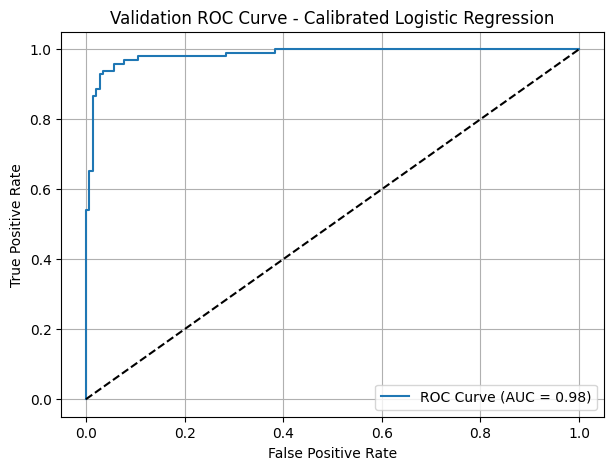

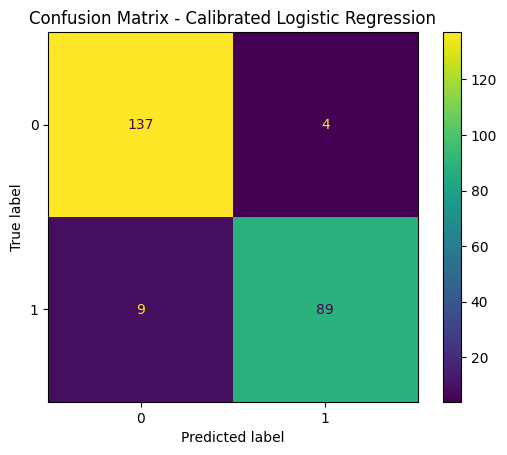

Classification Report:
              precision    recall  f1-score   support

           0       0.94      0.97      0.95       141
           1       0.96      0.91      0.93        98

    accuracy                           0.95       239
   macro avg       0.95      0.94      0.94       239
weighted avg       0.95      0.95      0.95       239

10-Fold CV AUC Scores:
[0.98505318 0.99022708 0.98907732 0.99971256 0.984      0.97055394
 0.99854227 0.98163265 0.9941691  0.99737609]
Mean AUC: 0.9890 ± 0.0086


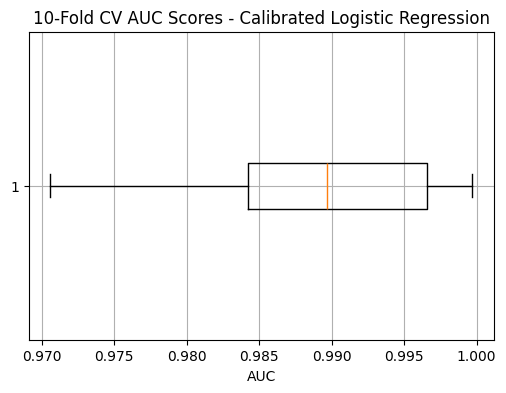

Best Parameters: {'estimator__C': 0.01, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}
Validation AUC: 0.9843682153712549
Training Accuracy: 0.9815899581589959


In [15]:
logreg = LogisticRegression(max_iter=1000)
cal_logreg = CalibratedClassifierCV(estimator=logreg, cv=3)

param_grid = {
    'estimator__C': [0.01, 0.1, 1, 10],
    'estimator__penalty': ['l2'],
    'estimator__solver': ['lbfgs']
}

grid = GridSearchCV(
    estimator=cal_logreg,
    param_grid=param_grid,
    cv=3,
    scoring='roc_auc',
    n_jobs=-1
)

grid.fit(X_train, y_train_split)

best_model = grid.best_estimator_

val_auc = evaluate_model(best_model, X_val, y_val, x_train_features, y_train, model_name="Calibrated Logistic Regression")

test_probs = best_model.predict_proba(x_test_features)[:, 1]
submission_df = pd.DataFrame({
    'vid_id': test_ids,
    'is_turkey': test_probs
})
submission_df.to_csv('submission_logistic.csv', index=False)

print("Best Parameters:", grid.best_params_)
print("Validation AUC:", val_auc)

train_preds = best_model.predict(x_train_features)
train_accuracy = accuracy_score(y_train, train_preds)

print("Training Accuracy:", train_accuracy)

Không có dấu hiệu rõ ràng của overfitting nghiêm trọng. Mức chênh lệch hiệu năng giữa train và validation là chấp nhận được

**Siêu tham số tối ưu được chọn:**
- Best Parameters: {'estimator__C': 0.01, 'estimator__penalty': 'l2', 'estimator__solver': 'lbfgs'}
---

### Đánh giá mô hình  Logistic Regression

#### Hiệu suất phân loại (Classification Performance)

**Báo cáo phân loại trên tập validation:**

| Chỉ số         | Lớp 0 (Không phải gà tây) | Lớp 1 (Gà tây) | Trung bình (macro) |
|----------------|----------------------------|----------------|---------------------|
| **Precision**  | 0.94                       | 0.96           | 0.95                |
| **Recall**     | 0.97                       | 0.91           | 0.94                |
| **F1-score**   | 0.95                       | 0.93           | 0.94                |
| **Accuracy**   |                            |                | **0.95**            |

- Mô hình đạt độ chính xác rất cao, với **f1-score trung bình đạt 0.94** và **accuracy 95%**, thể hiện hiệu suất phân loại ổn định.
- Lớp gà tây (lớp 1) được nhận diện tốt, với precision đạt 0.96 và recall đạt 0.91, cho thấy mô hình có khả năng phát hiện đúng đa số các mẫu dương. Có 9 mẫu nhận diện sai.

#### AUC trên Validation Set:
- Từ biểu đồ ROC curve, đường cong nằm gần phía góc trên bên trái, cách xa đường chéo, chứng tỏ khả năng phân biệt hai lớp rất tốt.
- **AUC = 0.98** → Khả năng phân biệt gần như tối ưu.

#### 10-Fold Cross Validation AUC:
- AUC Scores (10 lần gập):  
  `[0.9851, 0.9902, 0.9891, 0.9997, 0.9840, 0.9706, 0.9985, 0.9816, 0.9942, 0.9974]`
- **Mean AUC = 0.9890 ± 0.0086**
- Boxplot AUC cho thấy các điểm số rất cao và dao động thấp → hiệu suất ổn định giữa các fold khác nhau.

→ **Mô hình ổn định và có hiệu suất rất cao** trên nhiều tập con, cho thấy khả năng tổng quát hóa tốt.

#### Phân tích hạn chế và gợi ý cải thiện

##### Hạn chế:
- Mặc dù precision cao (0.96) cho lớp gà tây, recall (0.91) vẫn cho thấy một số mẫu dương bị bỏ sót.
- Một vài fold có AUC thấp hơn trung bình (ví dụ: 0.9706) → cần xem xét dữ liệu ở các fold này có thể có nhiễu hoặc chưa đại diện.

##### Cải thiện đề xuất:
- Có thể kết hợp mô hình này với SVC theo hình thức **voting ensemble** để tận dụng thế mạnh của cả hai mô hình.

#### Kết luận:
Mô hình **Calibrated Logistic Regression** thể hiện **hiệu suất vượt trội**, với **AUC xấp xỉ 0.99**, **độ chính xác và độ ổn định cao**. Đây là một mô hình đơn giản nhưng cực kỳ hiệu quả.

---

### Mô hình chính được đề xuất cải thiện: mô hình Voting Classifier kết hợp Pseudo-labeling.
- Mục tiêu:
    - Phát triển một mô hình phân loại nhị phân mạnh mẽ bằng cách:

      - Kết hợp nhiều mô hình con thông qua kỹ thuật Voting Ensemble để cải thiện hiệu quả dự đoán.

      - Áp dụng chiến lược pseudo-labeling để tận dụng tập dữ liệu chưa gán nhãn, từ đó mở rộng tập huấn luyện và tăng khả năng tổng quát hóa.
- Lựa chọn mô hình và chiến lược ensemble:
  - Các mô hình thành phần:
      - Calibrated SVM: mô hình SVC với xác suất được hiệu chỉnh bằng CalibratedClassifierCV, sử dụng siêu tham số tối ưu đã tìm được (C=10, kernel='rbf', gamma='auto).

      - Logistic Regression: sử dụng siêu tham số tốt nhất đã tìm được ở trên (C=0.01, penalty='l2', solver='lbfgs').

- Kỹ thuật ensemble:
    - Dùng VotingClassifier với chế độ "soft voting", tức là lấy trung bình xác suất của các mô hình thành phần để đưa ra quyết định cuối cùng. Điều này khai thác ưu điểm của từng mô hình trong việc dự đoán xác suất.

    - VotingClassifier giúp tăng tính ổn định và độ chính xác so với từng mô hình đơn lẻ.
- Đánh giá ban đầu với Cross-validation
    - Sử dụng 10-Fold Cross-validation trên tập huấn luyện (x_train_features, y_train) để đánh giá hiệu quả ensemble một cách khách quan.

    - Chỉ số đánh giá chính: ROC AUC.

    - Kết quả trung bình và độ lệch chuẩn được in ra và trực quan hóa bằng biểu đồ boxplot, giúp đánh giá độ ổn định và phân phối hiệu suất mô hình.
- Huấn luyện mô hình và Pseudo-labeling
  - Huấn luyện ban đầu:
      - Mô hình VotingClassifier được huấn luyện toàn bộ trên tập x_train_features.

      - Pseudo-labeling:
        - Dự đoán xác suất trên tập test (x_test_features) và chọn những mẫu có độ tin cậy cao:

        - Mẫu có xác suất > 0.9 được gán nhãn dương (1)

        - Mẫu có xác suất < 0.1 được gán nhãn âm (0)

        - Các mẫu này được gọi là pseudo-labeled data, giả định là đúng và dùng như dữ liệu huấn luyện bổ sung.

        - Tập huấn luyện mới được mở rộng bằng cách gộp các pseudo-labeled samples với dữ liệu gốc.

  - Huấn luyện lại:
      - Mô hình VotingClassifier được huấn luyện lại với tập huấn luyện mở rộng (X_extended, y_extended), giúp mô hình học được nhiều đặc trưng hơn và cải thiện hiệu suất.

  - Sau khi huấn luyện lại, mô hình được dùng để dự đoán xác suất trên tập test lần nữa.

- Kết quả được lưu vào file submission.csv dưới định dạng chuẩn (vid_id, is_turkey).

**Khai báo tham số tốt nhất cho các mô hình đã tìm được ở trên**

In [16]:
svm_best_params = {'C': 10, 'gamma': 'auto', 'kernel': 'rbf'}
logreg_best_params = {'C': 0.01, 'penalty': 'l2', 'solver': 'lbfgs'}

**Tạo mô hình SVM đã hiệu chỉnh và Logistic Regression**

In [17]:
svm = SVC(probability=True, C=svm_best_params['C'], gamma=svm_best_params['gamma'], kernel=svm_best_params['kernel'])
cal_svm = CalibratedClassifierCV(estimator=svm, cv=3)

logreg = LogisticRegression(C=logreg_best_params['C'], penalty=logreg_best_params['penalty'],
                            solver=logreg_best_params['solver'], max_iter=1000)

**Tạo Voting Classifier và đánh giá bằng cross-validation**

In [18]:
voting_clf = VotingClassifier(
    estimators=[('svm', cal_svm), ('logreg', logreg)],
    voting='soft',
    n_jobs=-1
)

cv_scores = cross_val_score(voting_clf, x_train_features, y_train, cv=10, scoring='roc_auc', n_jobs=-1)
print(f"10-Fold CV AUC Scores: {cv_scores}")
print(f"Mean AUC: {cv_scores.mean():.4f} ± {cv_scores.std():.4f}")

10-Fold CV AUC Scores: [0.98562805 0.98878988 0.988215   1.         0.98485714 0.9696793
 0.99737609 0.98134111 0.99387755 0.99650146]
Mean AUC: 0.9886 ± 0.0085


**Trực quan hóa điểm AUC**

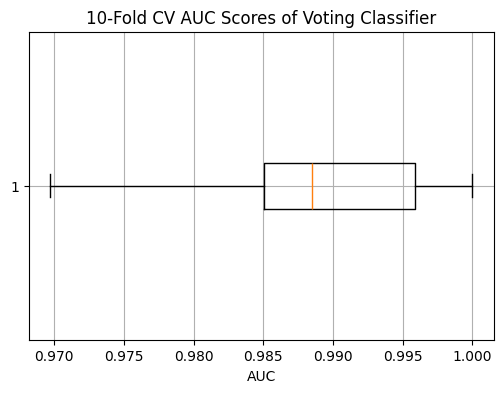

In [19]:
plt.figure(figsize=(6,4))
plt.boxplot(cv_scores, vert=False)
plt.title('10-Fold CV AUC Scores of Voting Classifier')
plt.xlabel('AUC')
plt.grid()
plt.show()

 **Huấn luyện mô hình với dữ liệu ban đầu và dự đoán xác suất trên tập test**

In [20]:
voting_clf.fit(x_train_features, y_train)
test_probs = voting_clf.predict_proba(x_test_features)[:, 1]

**Lọc ra các pseudo-label có độ tin cậy cao/thấp**

In [21]:
threshold_high = 0.9
threshold_low = 0.1

pseudo_labels_high = test_probs > threshold_high
pseudo_labels_low = test_probs < threshold_low

pseudo_indices = np.where(pseudo_labels_high | pseudo_labels_low)[0]
print(f"Số lượng mẫu pseudo-label: {len(pseudo_indices)}")


Số lượng mẫu pseudo-label: 969


**Tạo dữ liệu mở rộng và huấn luyện lại mô hình**

In [22]:
X_pseudo = x_test_features[pseudo_indices]
y_pseudo = (test_probs[pseudo_indices] > threshold_high).astype(int)

X_extended = np.vstack([x_train_features, X_pseudo])
y_extended = np.concatenate([y_train, y_pseudo])

voting_clf.fit(X_extended, y_extended)


VotingClassifier(estimators=[('svm',
                              CalibratedClassifierCV(cv=3,
                                                     estimator=SVC(C=10,
                                                                   gamma='auto',
                                                                   probability=True))),
                             ('logreg',
                              LogisticRegression(C=0.01, max_iter=1000))],
                 n_jobs=-1, voting='soft')

**Dự đoán xác suất cuối cùng và tạo file submission**

In [23]:
final_test_probs = voting_clf.predict_proba(x_test_features)[:, 1]

submission_df = pd.DataFrame({
    'vid_id': test_ids,
    'is_turkey': final_test_probs
})
submission_df.to_csv('submission.csv', index=False)

print("Pseudo-labeling + VotingClassifier training done. Submission file saved.")

Pseudo-labeling + VotingClassifier training done. Submission file saved.


---
### Đánh giá mô hình Pseudo-labeling + VotingClassifier

1. Kết quả Cross-Validation
- Mean AUC: 0.9886 ± 0.0085 là một kết quả rất tốt, cho thấy mô hình voting kết hợp SVM và Logistic Regression hoạt động mạnh mẽ, ổn định trên dữ liệu huấn luyện.

- Biến thiên nhỏ (±0.0085) chứng tỏ mô hình có độ ổn định tốt qua các fold, không bị ảnh hưởng nhiều bởi phân phối dữ liệu huấn luyện trong từng fold.

- Các fold đều có AUC cao > 0.96, đặc biệt có fold đạt 1.0 và nhiều fold trên 0.99, cho thấy hiệu quả mạnh mẽ của tổ hợp mô hình và khả năng phân biệt tốt giữa các lớp.

2. Số lượng mẫu pseudo-label: 969
- Với ngưỡng tự tin cao (0.9) và thấp (0.1), việc thu được 969 mẫu là một con số hợp lý:

- Nó cho thấy mô hình có khả năng đưa ra quyết định chắc chắn ở một lượng mẫu vừa phải.

- Giúp tăng cường tập huấn luyện mà không gây nhiễu quá nhiều do những dự đoán kém tin cậy.

- Đây là bước hợp lý để khai thác thông tin tiềm năng từ dữ liệu chưa gán nhãn, giúp mô hình học được thêm các mẫu đặc trưng.
3. Pseudo-Labeling & Huấn luyện lại
- Việc huấn luyện lại VotingClassifier với dữ liệu mở rộng là một chiến lược semi-supervised learning hiệu quả.

## Tài liệu tham khảo

- [Vector Embeddings Explained](https://www.couchbase.com/blog/what-are-vector-embeddings/)
- [Voting Classifier](https://scikit-learn.org/stable/modules/ensemble.html#voting-classifier)
- [Pseudo Labeling](https://viblo.asia/p/doi-dong-ve-pseudo-labeling-trong-machine-learning-1VgZvQmrKAw)